In [1]:
EPOCHS = 10
INLEN = 24          # input size
BLOCKS = 64         
LWIDTH = 32
BATCH = 64          # batch size
LEARN = 1e-3        # learning rate
VALWAIT = 1         # epochs to wait before evaluating the loss on the test/validation set
N_FC = 1            # output size

RAND = 42           # random seed
N_SAMPLES = 100     # number of times a prediction is sampled from a probabilistic model
N_JOBS = -1          # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9, 0.95, 0.99]

SPLIT = 0.9         # train/test %

FIGSIZE = (20, 7)


qL1, qL2, qL3 = 0.01, 0.05, 0.10        # percentiles of predictions: lower bounds
qU1, qU2, qU3 = 1-qL1, 1-qL2, 1-qL3     # upper bounds derived from lower bounds
label_q1 = f'{int(qU1 * 100)} / {int(qL1 * 100)} percentile band'
label_q2 = f'{int(qU2 * 100)} / {int(qL2 * 100)} percentile band'
label_q3 = f'{int(qU3 * 100)} / {int(qL3 * 100)} percentile band'

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import time

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)


from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import NBEATSModel, TFTModel, NaiveSeasonal, NaiveDrift, ExponentialSmoothing, NHiTSModel, TCNModel
from darts.metrics import mape, smape, mae, rmse, rmsle, r2_score
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import MissingValuesFiller
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


pd.set_option("display.precision",2)
np.set_printoptions(precision=2, suppress=True)
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
df = pd.read_parquet('AQI_Historical_New')
df = df[df['TRT_ID'].isin([77])]
df["dt"] = pd.to_datetime(df["dt"])

# EDA

In [4]:
# any duplicate time periods?
print("count of duplicates:",df.duplicated(subset=["dt"], keep="first").sum())

# any non-numeric types?
print("non-numeric columns:",list(df.dtypes[df.dtypes == "object"].index))

count of duplicates: 0
non-numeric columns: []


In [5]:
# convert int and float64 columns to float32
intcols = list(df.dtypes[df.dtypes == np.int64].index)
df[intcols] = df[intcols].applymap(np.float32)

f64cols = list(df.dtypes[df.dtypes == np.float64].index)
df[f64cols] = df[f64cols].applymap(np.float32)

<AxesSubplot:xlabel='dt', ylabel='components.pm2_5'>

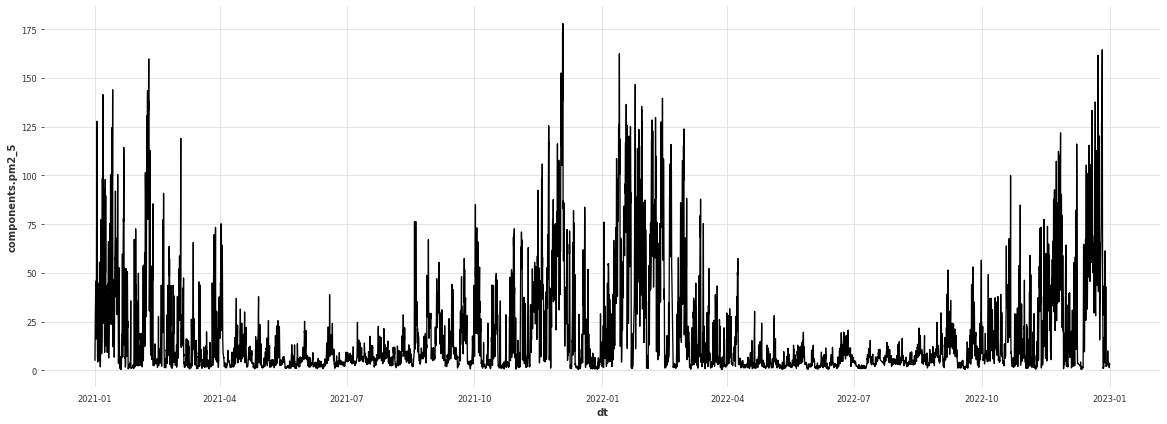

In [6]:
plt.figure(100, figsize=FIGSIZE)
sns.lineplot(x = "dt", y = "components.pm2_5", data = df, palette="coolwarm")

In [7]:
df.set_index('dt', inplace=True)

In [8]:
df_corr = df.corr(method="pearson")
print(df_corr.shape)
print("correlation with price:")
df_corrP = pd.DataFrame(df_corr["components.pm2_5"].sort_values(ascending=False))
df_corrP

(12, 12)
correlation with price:


,components.pm2_5
components.pm2_5,1.00
components.pm10,0.99
components.co,0.91
main.aqi,0.85
components.no,0.84
components.no2,0.80
components.nh3,0.74
components.so2,0.60
components.o3,-0.44
coord.lon,NaN


In [9]:
# highest absolute correlations with price
pd.options.display.float_format = '{:,.2f}'.format
df_corrH = df_corrP[np.abs(df_corrP["components.pm2_5"]) > 0.25]
df_corrH

,components.pm2_5
components.pm2_5,1.00
components.pm10,0.99
components.co,0.91
main.aqi,0.85
components.no,0.84
components.no2,0.80
components.nh3,0.74
components.so2,0.60
components.o3,-0.44


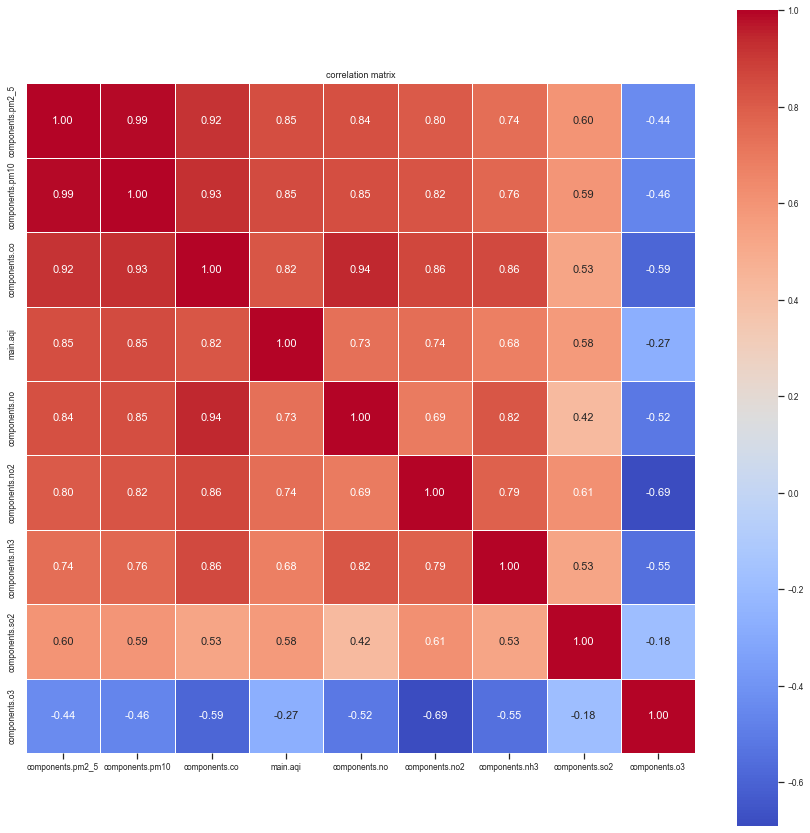

In [10]:
# correlation matrix, limited to highly correlated features
df3 = df[df_corrH.index]

idx = df3.corr().sort_values("components.pm2_5", ascending=False).index
df3_sorted = df3.loc[:, idx]  # sort dataframe columns by their correlation with Appliances

plt.figure(figsize = (15,15))
sns.set(font_scale=0.75)
ax = sns.heatmap(df3_sorted.corr().round(3), 
            annot=True, 
            square=True, 
            linewidths=.75, cmap="coolwarm", 
            fmt = ".2f", 
            annot_kws = {"size": 11})
ax.xaxis.tick_bottom()
plt.title("correlation matrix")
plt.show()

In [11]:
df3 = df[df_corrH.index]
df3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17304 entries, 2021-03-31 23:00:00 to 2022-09-30 22:00:00
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   components.pm2_5  17304 non-null  float32
 1   components.pm10   17304 non-null  float32
 2   components.co     17304 non-null  float32
 3   main.aqi          17304 non-null  float32
 4   components.no     17304 non-null  float32
 5   components.no2    17304 non-null  float32
 6   components.nh3    17304 non-null  float32
 7   components.so2    17304 non-null  float32
 8   components.o3     17304 non-null  float32
dtypes: float32(9)
memory usage: 743.5 KB


In [12]:
# additional datetime columns: feature engineering
df3["month"] = df3.index.month

df3["wday"] = df3.index.dayofweek
dict_days = {0:"1_Mon", 1:"2_Tue", 2:"3_Wed", 3:"4_Thu", 4:"5_Fri", 5:"6_Sat", 6:"7_Sun"}
df3["weekday"] = df3["wday"].apply(lambda x: dict_days[x])

df3["hour"] = df3.index.hour

df3 = df3.astype({"hour":float, "wday":float, "month": float})

df3.iloc[[0, -1]]

,components.pm2_5,components.pm10,components.co,main.aqi,components.no,components.no2,components.nh3,components.so2,components.o3,month,wday,weekday,hour
dt,,,,,,,,,,,,,
2021-03-31 23:00:00,17.18,22.20,270.37,4.00,0.74,6.86,2.50,3.93,185.97,3.00,2.00,3_Wed,23.00
2022-09-30 22:00:00,23.70,28.19,270.37,4.00,0.78,9.17,1.41,6.50,208.85,9.00,4.00,5_Fri,22.00


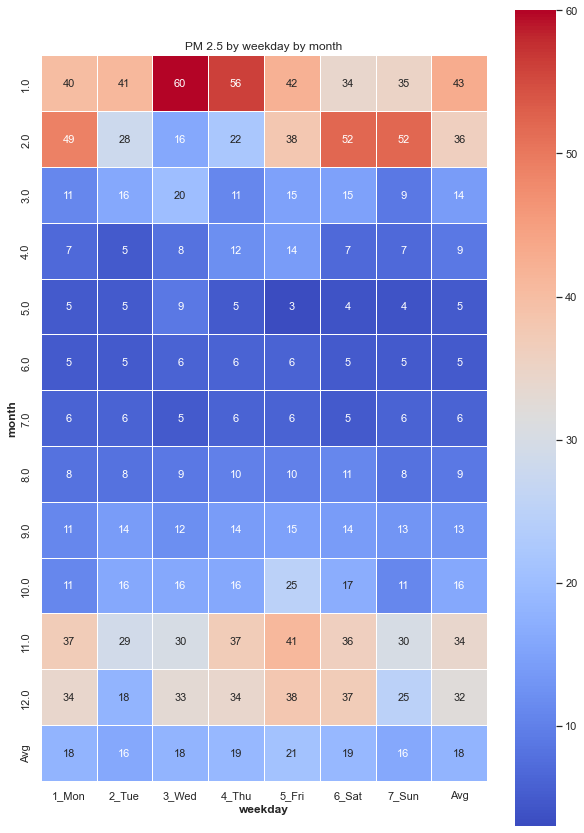

In [13]:
# pivot table: weekdays in months
piv = pd.pivot_table(   df3, 
                        values="components.pm2_5", 
                        index="month", 
                        columns="weekday", 
                        aggfunc="mean", 
                        margins=True, margins_name="Avg", 
                        fill_value=0)
pd.options.display.float_format = '{:,.0f}'.format

plt.figure(figsize = (10,15))
sns.set(font_scale=1)
sns.heatmap(piv.round(0), annot=True, square = True, \
            linewidths=.75, cmap="coolwarm", fmt = ".0f", annot_kws = {"size": 11})
plt.title("PM 2.5 by weekday by month")
plt.show()

In [14]:
df4 = df3.copy()
df4.drop(["weekday", "month", "wday", "hour"], inplace=True, axis=1)

# Data Processing

In [15]:
# create time series object for target variable
value_filler = MissingValuesFiller()
ts_P = value_filler.transform(TimeSeries.from_series(df4["components.pm2_5"], fill_missing_dates=True, freq='H'))

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)

components: Index(['components.pm2_5'], dtype='object', name='component')
duration: 729 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [16]:
# create time series object for the feature columns
df_covF = df4.loc[:, df4.columns != "components.pm2_5"]
ts_covF = value_filler.transform(TimeSeries.from_dataframe(df_covF, fill_missing_dates=True, freq='H'))

# check attributes of the time series
print("components (columns) of feature time series:", ts_covF.components)
print("duration:",ts_covF.duration)
print("frequency:",ts_covF.freq)
print("frequency:",ts_covF.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_covF.has_datetime_index)
print("deterministic:",ts_covF.is_deterministic)
print("univariate:",ts_covF.is_univariate)

components (columns) of feature time series: Index(['components.pm10', 'components.co', 'main.aqi', 'components.no',
       'components.no2', 'components.nh3', 'components.so2', 'components.o3'],
      dtype='object', name='component')
duration: 729 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [17]:
# train/test split and scaling of target variable
ts_train, ts_test = ts_P.split_after(SPLIT)
print("training start:", ts_train.start_time())
print("training end:", ts_train.end_time())
print("training duration:",ts_train.duration)
print("test start:", ts_test.start_time())
print("test end:", ts_test.end_time())
print("test duration:", ts_test.duration)


scalerP = Scaler()
scalerP.fit_transform(ts_train)
ts_ttrain = scalerP.transform(ts_train)
ts_ttest = scalerP.transform(ts_test)    
ts_t = scalerP.transform(ts_P)

# make sure data are of type float
ts_t = ts_t.astype(np.float32)
ts_ttrain = ts_ttrain.astype(np.float32)
ts_ttest = ts_ttest.astype(np.float32)

print("first and last row of scaled price time series:")
pd.options.display.float_format = '{:,.2f}'.format
ts_t.pd_dataframe().iloc[[0,-1]]

training start: 2021-01-01 00:00:00
training end: 2022-10-19 23:00:00
training duration: 656 days 23:00:00
test start: 2022-10-20 00:00:00
test end: 2022-12-31 23:00:00
test duration: 72 days 23:00:00
first and last row of scaled price time series:


component,components.pm2_5
dt,
2021-01-01 00:00:00,0.03
2022-12-31 23:00:00,0.02


In [18]:
# train/test split and scaling of feature covariates
covF_train, covF_test = ts_covF.split_after(SPLIT)

scalerF = Scaler()
scalerF.fit_transform(covF_train)
covF_ttrain = scalerF.transform(covF_train) 
covF_ttest = scalerF.transform(covF_test)   
covF_t = scalerF.transform(ts_covF)  

# make sure data are of type float
covF_ttrain = covF_ttrain.astype(np.float32)
covF_ttest = covF_ttest.astype(np.float32)

pd.options.display.float_format = '{:.2f}'.format
print("first and last row of scaled feature covariates:")
covF_t.pd_dataframe().iloc[[0,-1]]

first and last row of scaled feature covariates:


component,components.pm10,components.co,main.aqi,components.no,components.no2,components.nh3,components.so2,components.o3
dt,,,,,,,,
2021-01-01 00:00:00,0.04,0.05,0.00,0.01,0.09,0.03,0.12,0.15
2022-12-31 23:00:00,0.02,0.06,0.00,0.00,0.15,0.02,0.07,0.05


In [19]:
covT = datetime_attribute_timeseries( ts_P.time_index, attribute="hour", add_length=48 )   # 48 hours beyond end of test set to prepare for out-of-sample forecasting
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="day_of_week")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="month")  )
covT = covT.stack(  datetime_attribute_timeseries(covT.time_index, attribute="year")  )

covT = covT.add_holidays(country_code="US")
covT = covT.astype(np.float32)


# train/test split
covT_train, covT_test = covT.split_after(ts_train.end_time())


# rescale the covariates: fitting on the training set
scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_ttest = scalerT.transform(covT_test)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)


pd.options.display.float_format = '{:.0f}'.format
print("first and last row of unscaled time covariates:")
covT.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled time covariates:


component,hour,day_of_week,month,year,holidays
time,,,,,
2021-01-01 00:00:00,0,4,1,2021,1
2023-01-02 23:00:00,23,0,1,2023,1


In [20]:
# combine feature and time covariates along component dimension: axis=1
ts_cov = ts_covF.concatenate( covT.slice_intersect(ts_covF), axis=1 )                      # unscaled F+T
cov_t = covF_t.concatenate( covT_t.slice_intersect(covF_t), axis=1 )                       # scaled F+T
cov_ttrain = covF_ttrain.concatenate( covT_ttrain.slice_intersect(covF_ttrain), axis=1 )   # scaled F+T training set
cov_ttest = covF_ttest.concatenate( covT_ttest.slice_intersect(covF_ttest), axis=1 )       # scaled F+T test set


pd.options.display.float_format = '{:.2f}'.format
print("first and last row of unscaled covariates:")
ts_cov.pd_dataframe().iloc[[0,-1]]

first and last row of unscaled covariates:


component,components.pm10,components.co,main.aqi,components.no,components.no2,components.nh3,components.so2,components.o3,hour,day_of_week,month,year,holidays
dt,,,,,,,,,,,,,
2021-01-01 00:00:00,8.41,277.04,1.00,2.38,17.48,1.09,4.29,54.36,0.00,4.00,1.00,2021.00,1.00
2022-12-31 23:00:00,4.56,310.42,1.00,1.29,27.76,0.49,2.62,16.45,23.00,5.00,12.00,2022.00,0.00


# Hyperparameter Optimization

In [21]:
from pytorch_lightning.callbacks import EarlyStopping
from ray import tune
from ray.tune import CLIReporter
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection

In [35]:
def train_model(model_args, callbacks, train, val):
    torch_metrics = MetricCollection([MeanAbsolutePercentageError(), MeanAbsoluteError()])
    # Create the model using model_args from Ray Tune
    model = TCNModel(input_chunk_length=24,
                    output_chunk_length=1,
                    n_epochs=30,
                    torch_metrics=torch_metrics,
                    optimizer_kwargs={"lr": LEARN},
                    random_state=RAND,
                    likelihood=QuantileRegression(QUANTILES),
                    pl_trainer_kwargs={"callbacks": callbacks, 
                            "enable_progress_bar": False,
                            "accelerator": "gpu",
                            "devices": -1, 
                            "auto_select_gpus": True}
                    )

    # model = NBEATSModel(
    #     input_chunk_length=INLEN,
    #     output_chunk_length=1,
    #     n_epochs=5,
    #     likelihood=QuantileRegression(QUANTILES), 
    #     optimizer_kwargs={"lr": LEARN}, 
    #     torch_metrics=torch_metrics,
    #     random_state=RAND,
    #     pl_trainer_kwargs={"callbacks": callbacks, 
    #                        "enable_progress_bar": False, 
    #                        "accelerator": "gpu",
    #                        "devices": -1, 
    #                        "auto_select_gpus": True},
    #     **model_args)

    model.fit(series=train, 
            past_covariates=cov_t, 
            val_series=val, 
            val_past_covariates=cov_t, 
            verbose=True)

In [36]:
# Early stop callback
my_stopper = EarlyStopping(
    monitor="val_MeanAbsolutePercentageError",
    patience=5,
    min_delta=0.05,
    mode='min',
)

# set up ray tune callback
tune_callback = TuneReportCallback(
    {
        "loss": "val_Loss",
        "MAPE": "val_MeanAbsolutePercentageError",
    },
    on="validation_end",
)

# define the hyperparameter space
config = {
    #"full_attention": tune.choice([True, False]), #TFT
    #"lstm_layers": tune.choice([1,2,3,4]), #TFT
    #"hidden_size": tune.choice([2,4,8,16]), #TFT
     "kernel_size": tune.choice([1,2,3,4]),
    # "num_filters": tune.choice([1,2,3,4]),
    "batch_size": tune.choice([32, 64, 128]),
    "num_layers": tune.choice([None,1,2,3,4]),
    # "num_blocks": tune.choice([1, 2, 3, 4, 5]),
    #"num_stacks": tune.choice([32, 64, 128]),
    "dropout": tune.uniform(0, 0.2),
    #"layer_widths": tune.choice([16, 32, 64, 128])
}

reporter = CLIReporter(
    parameter_columns=list(config.keys()),
    metric_columns=["loss", "MAPE", "training_iteration"],
)

resources_per_trial = {"cpu": 8, "gpu": 1}

# the number of combinations to try
num_samples = 10

scheduler = ASHAScheduler(max_t=1000, grace_period=3, reduction_factor=2)

train_fn_with_parameters = tune.with_parameters(
    train_model, callbacks=[my_stopper, tune_callback], train=ts_ttrain, val=ts_ttest,
)

# optimize hyperparameters by minimizing the MAPE on the validation set
analysis = tune.run(
    train_fn_with_parameters,
    resources_per_trial=resources_per_trial,
    # Using a metric instead of loss allows for
    # comparison between different likelihood or loss functions.
    metric="MAPE",  # any value in TuneReportCallback.
    mode="min",
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter,
    name="tune_darts",
)

print("Best hyperparameters found were: ", analysis.best_config)

Trial name,MAPE,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_model_c23a2_00000,0.328311,2023-02-14_20-15-37,True,,cd720daa2c394ec8a61341481db45f0f,LNL-PW00N65N,13,127.0.0.1,18536,81.2889,6.0357,81.2889,1676402137,0,,13,c23a2_00000,0.00480723
train_model_c23a2_00001,0.414992,2023-02-14_20-16-23,True,,ab39343fb9514d298b69201c02436b2f,LNL-PW00N65N,6,127.0.0.1,4632,38.5244,6.02715,38.5244,1676402183,0,,6,c23a2_00001,0.00500154
train_model_c23a2_00002,0.799428,2023-02-14_20-16-50,True,,74c4e73beae341eda0750bfabc1e9147,LNL-PW00N65N,3,127.0.0.1,21092,20.5345,5.90311,20.5345,1676402210,0,,3,c23a2_00002,0.00399876
train_model_c23a2_00003,0.41502,2023-02-14_20-17-35,True,,790e68a5afeb40f5af150ce13505c6dc,LNL-PW00N65N,6,127.0.0.1,8384,38.3101,6.06756,38.3101,1676402255,0,,6,c23a2_00003,0.00500011
train_model_c23a2_00004,0.415757,2023-02-14_20-18-20,True,,a7bfca0f2b8c4287b87c5b91618c2826,LNL-PW00N65N,6,127.0.0.1,8096,38.2686,5.91155,38.2686,1676402300,0,,6,c23a2_00004,0.00534463
train_model_c23a2_00005,0.327495,2023-02-14_20-19-49,True,,7330ede5fc8040d49d792cda9945f2b6,LNL-PW00N65N,13,127.0.0.1,22392,80.9188,5.96238,80.9188,1676402389,0,,13,c23a2_00005,0.0050025
train_model_c23a2_00006,0.357136,2023-02-14_20-21-11,True,,de586ed8244744a499f85a7db834b598,LNL-PW00N65N,12,127.0.0.1,4420,75.3676,6.0668,75.3676,1676402471,0,,12,c23a2_00006,0.00500083
train_model_c23a2_00007,0.801664,2023-02-14_20-21-39,True,,238a3f2ba979419fb9faef436eaf8049,LNL-PW00N65N,3,127.0.0.1,12168,20.7272,6.0496,20.7272,1676402499,0,,3,c23a2_00007,0.0049994
train_model_c23a2_00008,0.797253,2023-02-14_20-22-07,True,,540e1b949ad04b418094baed6b76969f,LNL-PW00N65N,3,127.0.0.1,10572,20.9807,6.09663,20.9807,1676402527,0,,3,c23a2_00008,0.00462961
train_model_c23a2_00009,0.797937,2023-02-14_20-22-36,True,,727bbf1c20bb417ea7db339d8fdd0fd0,LNL-PW00N65N,3,127.0.0.1,21936,20.9667,6.11433,20.9667,1676402556,0,,3,c23a2_00009,0.0059998


(train_model pid=21936) 
Epoch 2: 100%|██████████| 546/546 [00:06<00:00, 89.44it/s, loss=0.0531, train_loss=0.0637, val_loss=0.132, val_MeanAbsolutePercentageError=1.250, val_MeanAbsoluteError=0.0639, train_MeanAbsolutePercentageError=14.70, train_MeanAbsoluteError=0.0527]
== Status ==
Current time: 2023-02-14 20:22:36 (running for 00:08:26.51)
Memory usage on this node: 17.2/31.7 GiB 
Using AsyncHyperBand: num_stopped=8
Bracket: Iter 768.000: None | Iter 384.000: None | Iter 192.000: None | Iter 96.000: None | Iter 48.000: None | Iter 24.000: None | Iter 12.000: -0.3545258045196533 | Iter 6.000: -0.4149499833583832 | Iter 3.000: -0.7970417439937592
Resources requested: 0/16 CPUs, 0/1 GPUs, 0.0/9.92 GiB heap, 0.0/4.96 GiB objects
Current best trial: c23a2_00005 with MAPE=0.32749494910240173 and parameters={'kernel_size': 3, 'batch_size': 128, 'num_layers': 3, 'dropout': 0.07030873921960888}
Result logdir: C:\Users\fashaikh\ray_results\tune_darts
Number of trials: 10/10 (10 TERMINATED)


In [24]:
print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'batch_size': 32, 'num_stacks': 32, 'dropout': 0.16164555061342992, 'layer_widths': 64}


# N-BEATS MODEL

In [29]:
def build_model_NBEATS():
    model = NBEATSModel(input_chunk_length=INLEN,
                        output_chunk_length=1, 
                        num_stacks=32, #128
                        layer_widths=64, #LWIDTH
                        batch_size=32,#BATCH,
                        n_epochs=EPOCHS,
                        dropout=0.16164555061342992,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NBEATS",
                        log_tensorboard=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True,
                        pl_trainer_kwargs={
                            "accelerator": "gpu",
                            "devices": -1, 
                            "auto_select_gpus": True}
                        )

    model.fit(series=ts_ttrain, 
            past_covariates=cov_t, 
            val_series=ts_ttest, 
            val_past_covariates=cov_t, 
            verbose=True)

    
    return model

In [30]:
def model_predict(model, n, past_covariates):
    pred = model.predict(n=n,  
                            past_covariates=past_covariates,
                            num_samples=N_SAMPLES,   
                            n_jobs=N_JOBS, 
                            verbose=True)
    return pred

In [31]:
nbeats_model = build_model_NBEATS()
ts_pred = model_predict(nbeats_model, len(ts_ttest), cov_t)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [32]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)

# helper function: get forecast values for selected quantile q and insert them in dataframe dfY
def predQ(ts_t, q):
    ts_tq = ts_t.quantile_timeseries(q)
    ts_q = scalerP.inverse_transform(ts_tq)
    s = TimeSeries.pd_series(ts_q)
    header = "Q" + format(int(q*100), "02d")
    dfY[header] = s
    if q==0.5:
        ts_q50 = ts_q
        q50_RMSE = rmse(ts_q50, ts_test)
        q50_MAPE = mape(ts_q50, ts_test) 
        q50_MAE = mae(ts_q50, ts_test)
        q50_R2 = r2_score(ts_q50, ts_test)
        print("RMSE:", f'{q50_RMSE:.2f}')
        print("MAPE:", f'{q50_MAPE:.2f}')
        print("MAE:", f'{q50_MAE:.2f}')
        print("R2:", f'{q50_R2:.2f}')
  
    
# call helper function predQ, once for every quantile
_ = [predQ(ts_pred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 7.73
MAPE: 24.58
MAE: 5.02
R2: 0.93


,Actual,Q50,Q01,Q05,Q10,Q20,Q25,Q75,Q80,Q90,Q95,Q99
dt,,,,,,,,,,,,
2022-10-20 00:00:00,21.90,24.35,10.12,19.40,20.32,20.60,21.55,26.98,28.18,32.07,33.38,50.07
2022-10-20 01:00:00,23.59,24.69,6.65,19.65,20.40,21.44,22.11,27.89,29.48,32.62,35.30,44.50
2022-12-31 22:00:00,2.80,4.56,-7.55,-5.10,-0.27,1.50,2.05,5.53,5.98,8.49,9.72,11.73
2022-12-31 23:00:00,3.44,5.93,-2.75,1.71,2.63,3.52,3.69,7.22,7.49,9.85,11.19,18.45


In [33]:
# plot the forecast
def plot_model(dfY):
    plt.figure(100, figsize=(20, 7))
    sns.set(font_scale=1.3)
    p = sns.lineplot(x = "dt", y = "Q50", data = dfY, palette="coolwarm")
    sns.lineplot(x = "dt", y = "Actual", data = dfY, palette="coolwarm")
    #sns.lineplot(x = "dt", y = "Q99", data = dfY, palette="coolwarm")
    #sns.lineplot(x = "dt", y = "Q95", data = dfY, palette="coolwarm")
    #sns.lineplot(x = "dt", y = "Q90", data = dfY, palette="coolwarm")
    plt.legend(labels=["forecast median PM 2.5 Q50", "actual Pm 2.5"])
    p.set_ylabel("Pm 2.5 Concentration")
    p.set_xlabel("")
    p.set_title("PM 2.5 Concentration (test set)")

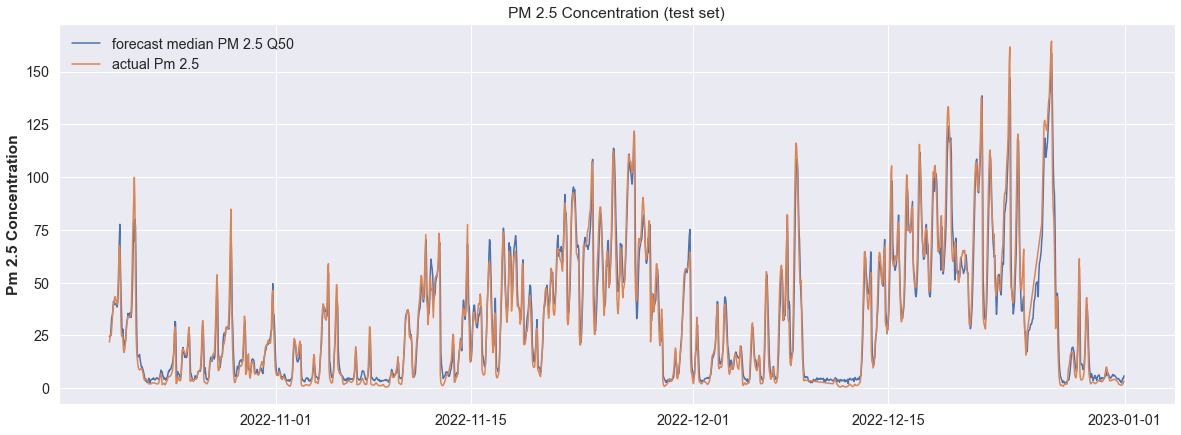

In [34]:
plot_model(dfY)

In [27]:
# choose forecast horizon: k hours beyond end of test set
k = 24   

n_FC = k + len(ts_ttest)   # length of test set + k hours
print("forecast beyond end of training set:", n_FC, 
      "hours beyond", ts_ttrain.end_time())

# last 24 hours of feature covariates available => copy them to future 24 hours:
covF_t_fut = covF_t.concatenate(other=covF_t.tail(size=24), ignore_time_axis=True)
# combine feature and time covariates:
cov_t_fut = covF_t_fut.concatenate(covT_t.slice_intersect(covF_t_fut), axis=1) 
cov_t_fut.pd_dataframe().iloc[[0,-1]]

forecast beyond end of training set: 1776 hours beyond 2022-10-19 23:00:00


component,components.pm10,components.co,main.aqi,components.no,components.no2,components.nh3,components.so2,components.o3,hour,day_of_week,month,year,holidays
dt,,,,,,,,,,,,,
2021-01-01 00:00:00,0.04,0.05,0.00,0.01,0.09,0.03,0.12,0.15,0.00,0.67,0.00,0.00,1.00
2023-01-01 23:00:00,0.02,0.06,0.00,0.00,0.15,0.02,0.07,0.05,1.00,1.00,0.00,2.00,1.00


In [29]:
# forecast from end of training set until k hours beyond end of test set
ts_tpred = model_predict(nbeats_model, n_FC, cov_t_fut)
print("start:", ts_tpred.start_time(), "; end:",ts_tpred.end_time())

Predicting: 0it [00:00, ?it/s]

start: 2022-10-20 00:00:00 ; end: 2023-01-01 23:00:00


In [30]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
#dfY["Actual"] = TimeSeries.pd_series(ts_test)
 
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left, then insert Actual column
col = dfY.pop("Q50")
dfY.insert(0, col.name, col)
dfY.insert(0, "Actual", TimeSeries.pd_series(ts_test))

# show first and last 13 timestamps of forecast
dfY.iloc[np.r_[0:1, -13:0]]  

RMSE: 9.10
MAPE: 26.00
MAE: 5.82
SMAPE: 26.63
RMSLE: 0.33
R2: 0.88


,Actual,Q50,Q01,Q05,Q10,Q20,Q25,Q75,Q80,Q90,Q95,Q99
dt,,,,,,,,,,,,
2022-10-20 00:00:00,21.90,22.23,8.02,11.31,19.35,20.01,20.41,25.76,26.06,28.53,29.58,31.62
2023-01-01 11:00:00,NaN,3.91,-5.42,0.69,2.69,2.81,2.99,4.77,5.00,6.44,7.13,7.95
2023-01-01 12:00:00,NaN,3.23,-5.80,-4.48,2.47,2.77,2.80,4.39,4.60,5.00,6.11,7.60
2023-01-01 13:00:00,NaN,4.37,-4.72,-1.10,3.24,3.55,3.62,5.41,5.58,6.14,6.93,8.47
2023-01-01 14:00:00,NaN,4.18,-5.02,-3.32,2.85,3.30,3.44,5.61,6.27,7.41,7.94,8.54
2023-01-01 15:00:00,NaN,4.70,-4.88,-4.04,1.10,3.88,4.06,5.83,6.16,6.81,8.57,8.99
2023-01-01 16:00:00,NaN,4.41,-4.81,1.27,2.71,3.73,3.87,5.53,5.95,6.80,7.31,8.74
2023-01-01 17:00:00,NaN,3.27,-5.70,-4.34,1.68,2.65,2.87,4.35,4.74,6.35,7.36,7.91
2023-01-01 18:00:00,NaN,2.67,-6.98,-2.11,1.26,1.70,1.87,3.44,3.60,4.78,6.27,7.04


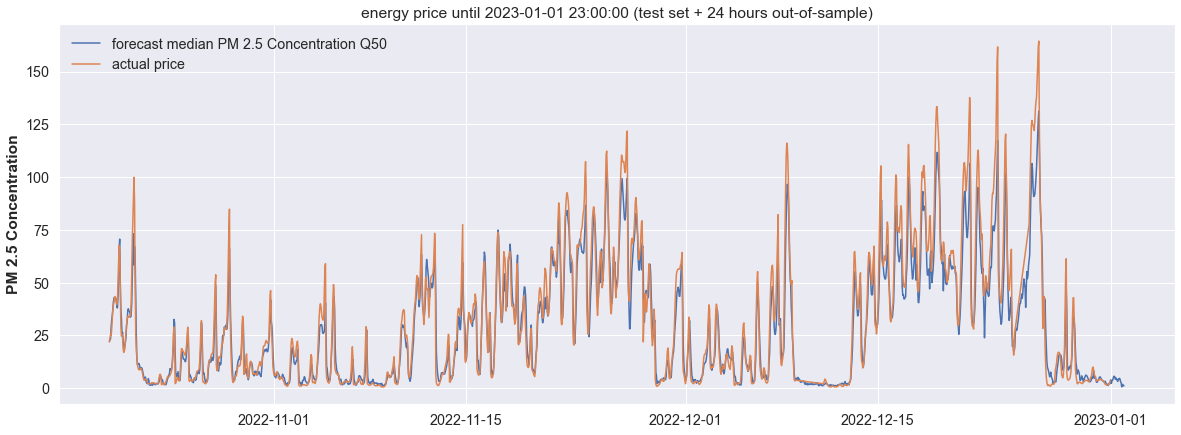

In [31]:
# plot the forecast
plt.figure(100, figsize=(20, 7))
sns.set(font_scale=1.3)
p = sns.lineplot(x = "dt", y = "Q50", data = dfY, palette="coolwarm")
sns.lineplot(x = "dt", y = "Actual", data = dfY, palette="coolwarm")
plt.legend(labels=["forecast median PM 2.5 Concentration Q50", "actual price"])
p.set_ylabel("PM 2.5 Concentration")
p.set_xlabel("")
end = ts_tpred.end_time()
p.set_title("energy price until {} (test set + {} hours out-of-sample)".format(end, k));

In [32]:
# out-of-sample forecast just as long as output chunk length = 1

ts_tpred = model_predict(nbeats_model, len(ts_ttest) + 1, cov_t)
print("start:", ts_tpred.start_time(), "; end:",ts_tpred.end_time())


q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
#dfY["Actual"] = TimeSeries.pd_series(ts_test)
 
# call helper function predQ, once for every quantile
_ = [predQ(ts_tpred, q) for q in QUANTILES]

# move Q50 column to the left, then insert Actual column
col = dfY.pop("Q50")
dfY.insert(0, col.name, col)
dfY.insert(0, "Actual", TimeSeries.pd_series(ts_test))

# show first and last 13 timestamps of forecast
dfY.iloc[np.r_[0:1, -13:0]]  

Predicting: 0it [00:00, ?it/s]

start: 2022-10-20 00:00:00 ; end: 2023-01-01 00:00:00
RMSE: 9.10
MAPE: 26.01
MAE: 5.83
SMAPE: 26.68
RMSLE: 0.32
R2: 0.88


,Actual,Q50,Q01,Q05,Q10,Q20,Q25,Q75,Q80,Q90,Q95,Q99
dt,,,,,,,,,,,,
2022-10-20 00:00:00,21.90,22.49,6.12,12.35,18.46,19.99,20.19,25.19,25.71,26.42,29.90,31.89
2022-12-31 12:00:00,3.13,3.12,-5.61,-5.11,-2.00,2.37,2.48,3.82,4.00,4.67,5.20,7.26
2022-12-31 13:00:00,2.60,2.74,-6.30,-5.53,1.22,2.15,2.26,3.65,3.84,4.26,5.78,6.92
2022-12-31 14:00:00,2.01,3.21,1.39,1.96,2.31,2.53,2.56,4.07,4.26,5.07,6.68,6.97
2022-12-31 15:00:00,1.79,3.03,-6.79,1.50,2.33,2.47,2.53,4.10,4.54,6.40,6.78,7.08
2022-12-31 16:00:00,1.69,1.82,-5.97,0.83,1.15,1.29,1.40,3.04,3.28,5.24,5.68,6.00
2022-12-31 17:00:00,1.52,1.40,-7.79,-7.54,-6.26,0.87,0.98,2.19,2.39,3.43,4.88,5.47
2022-12-31 18:00:00,1.45,1.87,-7.04,-5.75,1.19,1.38,1.46,3.02,3.17,5.15,5.88,6.04
2022-12-31 19:00:00,1.48,1.51,-7.43,-6.07,0.78,0.92,1.08,2.33,2.45,2.70,3.80,4.97


# NAIVE BASELINE

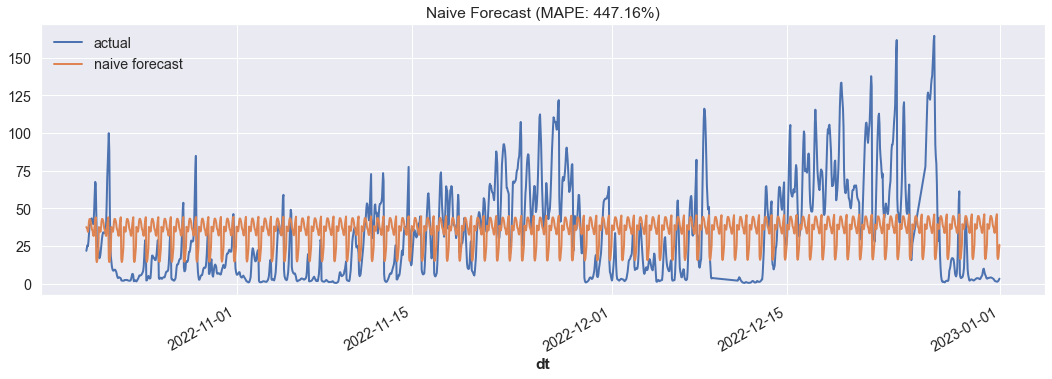

In [33]:
# naive seasonal forecast
modelNs = NaiveSeasonal(K=24)
modelNs.fit(ts_train)
ts_predNs = modelNs.predict(len(ts_test))

# naive drift (trend) forecast
modelNd = NaiveDrift()
modelNd.fit(ts_train)
ts_predNd = modelNd.predict(len(ts_test))

ts_predN = ts_predNd + ts_predNs - ts_train.last_value()

plt.figure(100, figsize=(18, 5))
ts_test.plot(label="actual")
ts_predN.plot(label="naive forecast")
plt.title("Naive Forecast (MAPE: {:.2f}%)".format(mape(ts_test, ts_predN)))
plt.legend()

# EXPONENTIAL SMOOTHING

c:\Users\fashaikh\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


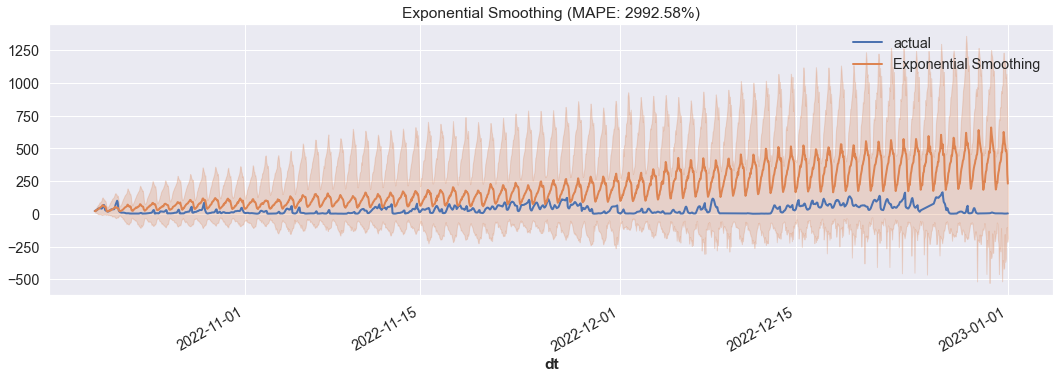

In [34]:
modelX = ExponentialSmoothing(
                seasonal_periods=24, 
                seasonal=ModelMode.MULTIPLICATIVE)
modelX.fit(ts_train)
ts_predX = modelX.predict(  n=len(ts_test), 
                            num_samples=N_SAMPLES)

plt.figure(100, figsize=(18, 5))
ts_test.plot(label="actual")
ts_predX.plot(label="Exponential Smoothing")
plt.title("Exponential Smoothing (MAPE: {:.2f}%)".format(mape(ts_test, ts_predX)))
plt.legend()

# TFT MODEL

In [99]:
model_tft = TFTModel(input_chunk_length=INLEN,
                output_chunk_length=1,
                hidden_size=16,
                full_attention=True,
                dropout=0.0179168599383444,
                batch_size=64,
                n_epochs=EPOCHS,
                likelihood=QuantileRegression(QUANTILES), 
                #loss_fn=MSELoss(),
                random_state=RAND, 
                force_reset=True,
                add_relative_index=True,
                pl_trainer_kwargs={
                        "accelerator": "gpu",
                        "devices": -1, 
                        "auto_select_gpus": True})

In [100]:
# training
model_tft.fit(series=ts_ttrain, 
        past_covariates=cov_t, 
        val_series=ts_ttest, 
        val_past_covariates=cov_t, 
        verbose=True)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [101]:
tft_pred = model_predict(model_tft, len(ts_ttest), cov_t)

Predicting: 0it [00:00, ?it/s]

In [102]:
print("Do the predictions constitute a probabilistic time series?", tft_pred.is_probabilistic)

Do the predictions constitute a probabilistic time series? True


In [103]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)

# call helper function predQ, once for every quantile
_ = [predQ(tft_pred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 8.42
MAPE: 21.57
MAE: 5.06
R2: 0.92


,Actual,Q50,Q01,Q05,Q10,Q20,Q25,Q75,Q80,Q90,Q95,Q99
dt,,,,,,,,,,,,
2022-10-20 00:00:00,21.90,27.59,8.93,21.45,23.30,24.00,24.80,29.74,31.70,32.97,35.03,39.24
2022-10-20 01:00:00,23.59,26.53,8.79,16.58,19.53,22.72,23.28,30.31,32.70,35.71,37.97,38.40
2022-12-31 22:00:00,2.80,2.33,-6.13,0.18,0.48,1.72,1.88,3.06,3.49,4.17,4.51,4.93
2022-12-31 23:00:00,3.44,3.19,-6.37,-1.92,1.00,2.19,2.35,3.90,4.58,5.10,5.38,6.07


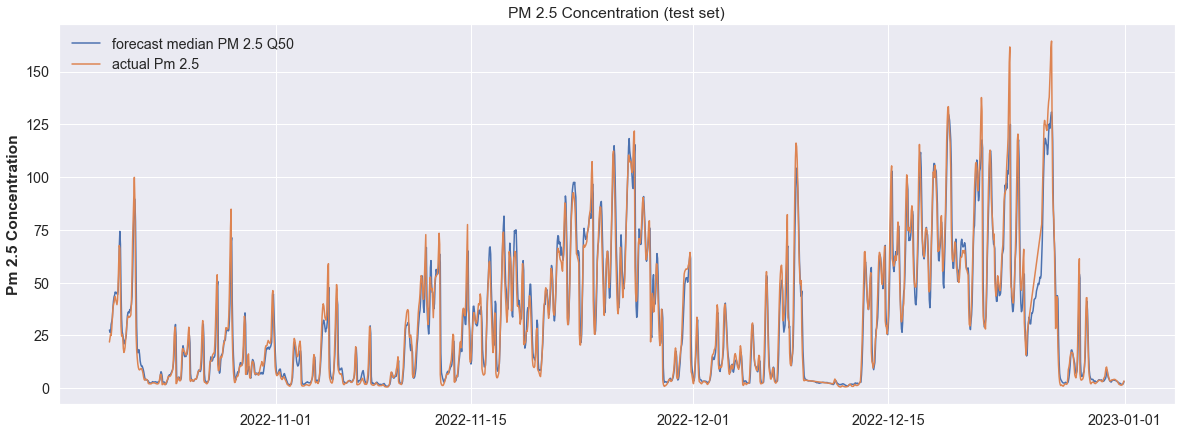

In [104]:
plot_model(dfY)

In [96]:
# testing: helper function: plot predictions
def plot_predict(ts_actual, ts_test, ts_pred):
    
    ## plot time series, limited to forecast horizon
    plt.figure(figsize=FIGSIZE)
    
    ts_test.plot(label="actual")                                       # plot actual
    
    #ts_pred.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)    # plot U1 quantile band
    #ts_pred.plot(low_quantile=qL2, high_quantile=qU2, label=label_q2)   # plot U2 quantile band
    #ts_pred.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)    # plot U3 quantile band
    ts_pred.plot(central_quantile="mean", label="expected")              # plot "mean" or median=0.5
    
    plt.title("TFT: test set (MAPE: {:.2f}%)".format(mape(ts_test, ts_pred)))
    plt.legend();    

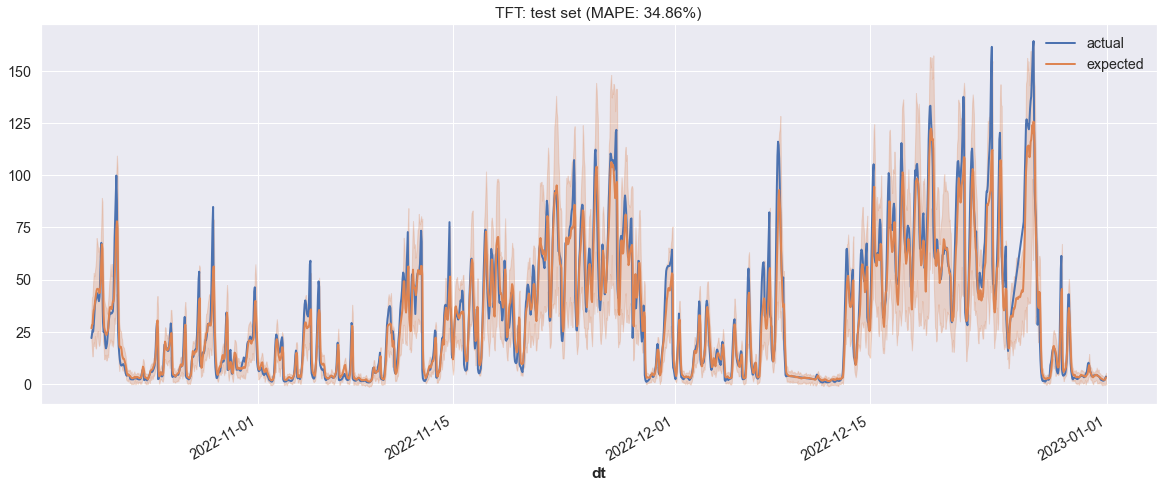

In [97]:
# testing: call helper function: plot predictions
tft_pred = scalerP.inverse_transform(tft_pred)
plot_predict(ts_P, ts_test, tft_pred)

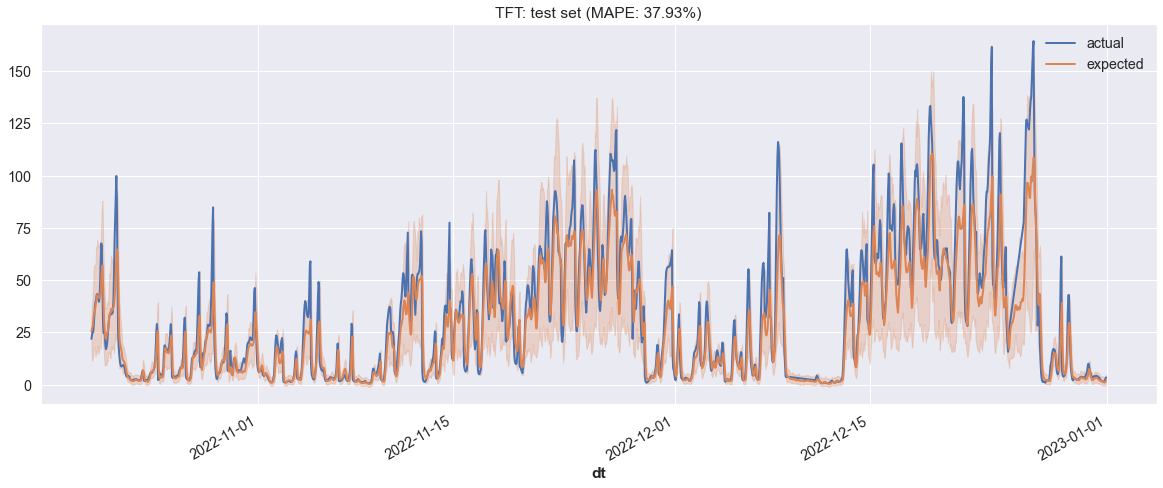

In [62]:
ts_actual = ts_P[ ts_tpred.start_time(): ts_tpred.end_time() ]  # actual values in forecast horizon
plot_predict(ts_actual, ts_test, tft_pred)

In [63]:
# backtest the model: predictions vs actual values

ts_tbacktest = model_tft.historical_forecasts(  series=ts_t,
                                            past_covariates=cov_t, 
                                            start=0.9,  
                                            num_samples=N_SAMPLES,
                                            forecast_horizon=len(ts_test),
                                            stride=12,
                                            last_points_only=False,
                                            retrain=False,
                                            verbose=False)

In [64]:
# backtesting: helper function: plot backtest predictions
def plot_backtest(ts_backtest, ts_actual):
    plt.figure(figsize=FIGSIZE)
    ts_actual.plot(label="actual")
    ts_backtest.plot(low_quantile=qL1, high_quantile=qU1, label=label_q1)
    ts_backtest.plot(low_quantile=qL3, high_quantile=qU3, label=label_q3)
    plt.legend()
    MAPE = "MAPE: {:.2f}%".format(mape(ts_backtest,ts_actual))
    plt.title(  "TFT: backtest from " + \
                format(ts_backtest.start_time(), "%Y.%m") + \
                " to " + format(ts_backtest.end_time(), "%Y.%m") + \
                "  (" + MAPE + ")")

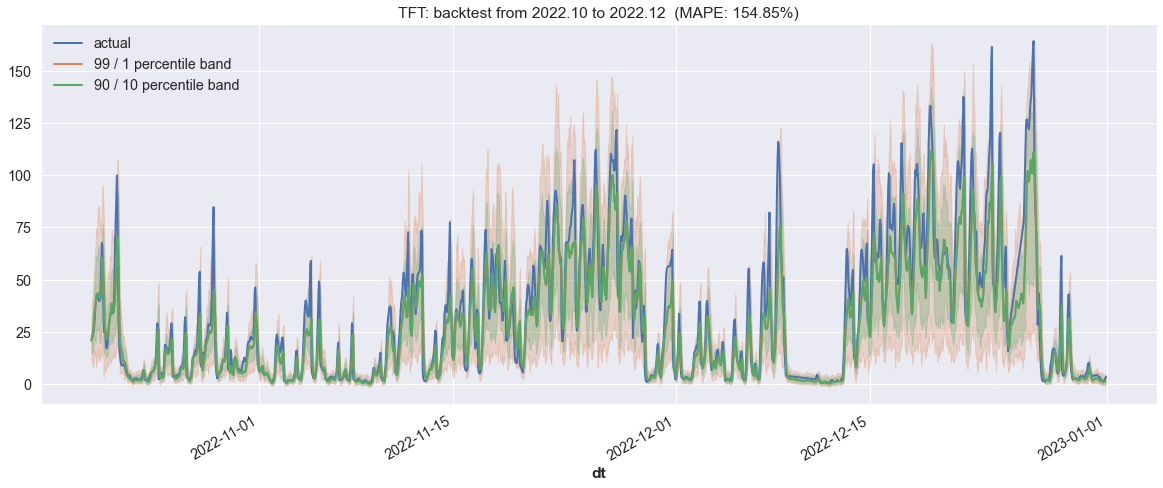

In [65]:
# backtesting: call helper function: plot backtest
ts_backtest = scalerP.inverse_transform(ts_tbacktest)

plot_backtest(ts_backtest=concatenate(ts_backtest), ts_actual=ts_test)

# DEEP TCN MODEL

In [37]:
def build_model_DeepTCN():
    model = TCNModel(input_chunk_length=24,
                    output_chunk_length=1,
                    kernel_size=3,
                    dropout=0.07030873921960888,
                    num_layers=3,
                    batch_size=128,#BATCH,
                    n_epochs=30,
                    optimizer_kwargs={"lr": LEARN},
                    random_state=RAND,
                    likelihood=QuantileRegression(QUANTILES),
                    pl_trainer_kwargs={
                            "accelerator": "gpu",
                            "devices": -1, 
                            "auto_select_gpus": True}
                    )
    model.fit(series=ts_ttrain, 
            past_covariates=cov_t, 
            val_series=ts_ttest, 
            val_past_covariates=cov_t, 
            verbose=True)

    
    return model

In [38]:
deeptcn_model = build_model_DeepTCN()
ts_pred = model_predict(deeptcn_model, len(ts_ttest), cov_t)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [39]:
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)

# call helper function predQ, once for every quantile
_ = [predQ(ts_pred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 25.00
MAPE: 71.09
MAE: 16.13
R2: -2.71


,Actual,Q50,Q01,Q05,Q10,Q20,Q25,Q75,Q80,Q90,Q95,Q99
dt,,,,,,,,,,,,
2022-10-20 00:00:00,21.90,23.36,8.24,18.10,20.04,20.52,20.66,25.49,26.29,29.29,30.56,31.75
2022-10-20 01:00:00,23.59,21.95,0.89,5.56,14.10,17.79,18.68,25.52,26.12,27.59,28.39,32.16
2022-12-31 22:00:00,2.80,2.25,0.73,0.95,1.32,1.57,1.68,3.08,3.15,4.11,4.73,5.60
2022-12-31 23:00:00,3.44,2.84,0.94,1.25,1.38,1.97,2.10,3.46,3.71,4.74,4.99,6.00


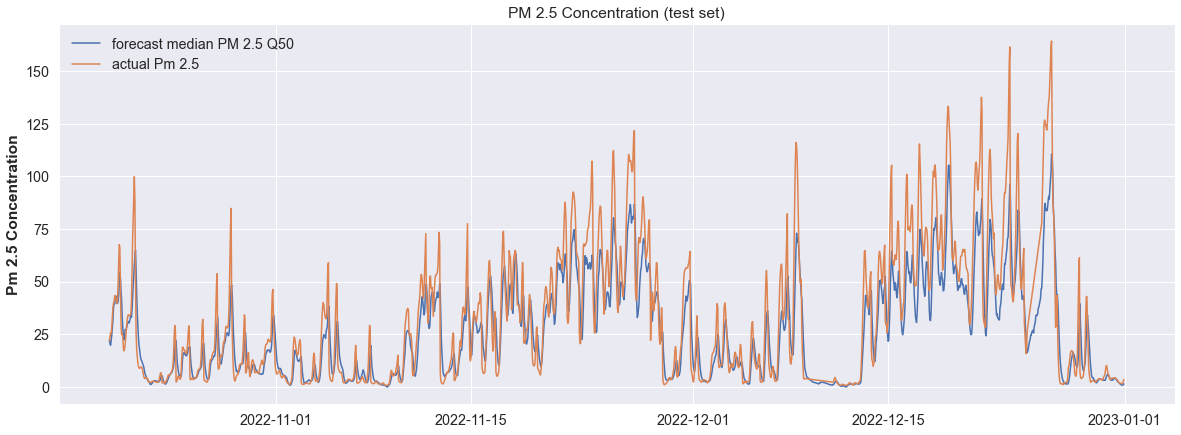

In [50]:
plot_model(dfY)

# N-HiTS MODEL

In [61]:
def build_model_NHiTS():
    model = NHiTSModel(input_chunk_length=24,
                        output_chunk_length=1, 
                        num_stacks=32, #BLOCKS,
                        num_layers=1,
                        layer_widths=LWIDTH,
                        batch_size=128, 
                        num_blocks=1, #BATCH,
                        n_epochs=EPOCHS,
                        dropout=0.19325426421237946,
                        nr_epochs_val_period=VALWAIT, 
                        likelihood=QuantileRegression(QUANTILES), 
                        optimizer_kwargs={"lr": LEARN}, 
                        model_name="NHiTS",
                        log_tensorboard=True, 
                        random_state=RAND,
                        force_reset=True,
                        save_checkpoints=True,
                        pl_trainer_kwargs={
                            "accelerator": "gpu",
                            "devices": -1, 
                            "auto_select_gpus": True}
                        )

    model.fit(series=ts_ttrain, 
            past_covariates=cov_t, 
            val_series=ts_ttest, 
            val_past_covariates=cov_t, 
            verbose=True)

    
    return model

In [62]:
nhits_model = build_model_NHiTS()
ts_pred = model_predict(nhits_model, len(ts_ttest), cov_t)

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

In [63]:
# retrieve forecast series for chosen quantiles, 
# inverse-transform each series,
# insert them as columns in a new dataframe dfY
q50_RMSE = np.inf
q50_MAPE = np.inf
ts_q50 = None
pd.options.display.float_format = '{:,.2f}'.format
dfY = pd.DataFrame()
dfY["Actual"] = TimeSeries.pd_series(ts_test)

# call helper function predQ, once for every quantile
_ = [predQ(ts_pred, q) for q in QUANTILES]

# move Q50 column to the left of the Actual column
col = dfY.pop("Q50")
dfY.insert(1, col.name, col)
dfY.iloc[np.r_[0:2, -2:0]]

RMSE: 9.06
MAPE: 28.02
MAE: 5.91
R2: 0.89


,Actual,Q50,Q01,Q05,Q10,Q20,Q25,Q75,Q80,Q90,Q95,Q99
dt,,,,,,,,,,,,
2022-10-20 00:00:00,21.90,21.24,6.81,14.07,16.73,18.26,18.95,24.57,25.07,32.61,36.09,42.80
2022-10-20 01:00:00,23.59,22.96,4.10,14.89,16.42,18.49,19.58,26.51,27.36,31.73,34.31,40.52
2022-12-31 22:00:00,2.80,1.84,-2.76,-0.72,-0.00,1.63,1.69,2.33,2.52,4.61,6.25,12.67
2022-12-31 23:00:00,3.44,2.19,-4.58,-3.44,-0.31,1.25,1.97,3.03,3.14,4.60,7.37,13.44


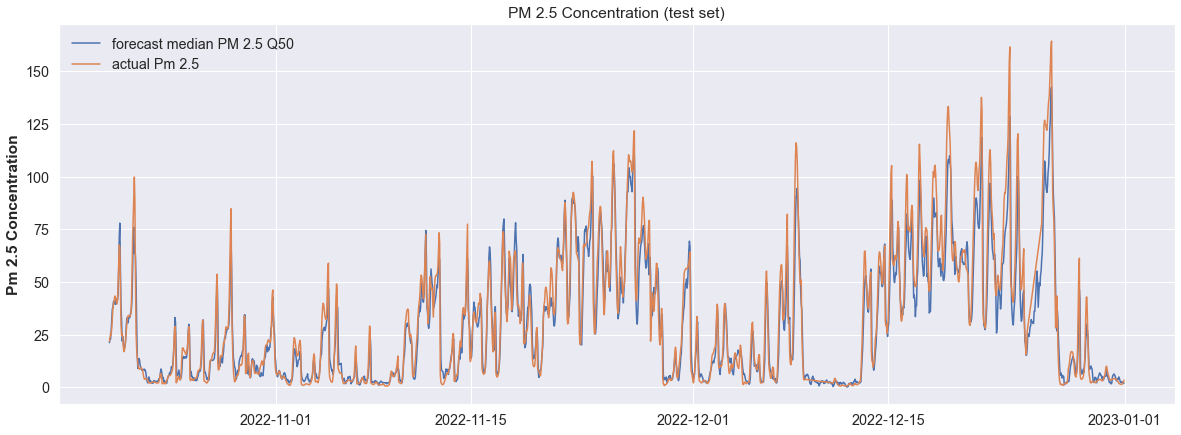

In [66]:
plot_model(dfY)